In [104]:
# This notebook analyses the ouput of 
# running complexity.py

# ! grep 'for_parser:' val_csv_all_models_all_cities/complexity_results_all_cities_io_pred_horiz_combo_results_thin_margin.txt | sed "s/for_parser:,//g" > val_csv_all_models_all_cities/PM_all_cities_io_pred_combo.csv
# ! grep 'for_parser:' complexity_results_all_cities_io_4_only_back_margins_wide.txt | sed "s/for_parser:,//g" > PM_complexity_results_all_cities_io_4_only_back_margins_wide.csv

In [7]:
import sys
import os

sys.path.append("../")
# ! pip install -r ../../../requirements.txt
import config

import numpy as np
import matplotlib.pyplot as plt
from smartprint import smartprint as sprint
from preprocessing.ProcessRaw import ProcessRaw
import pandas as pd

In [8]:
city_color = {"london" : "red", 
             "melbourne": "blue",
             "madrid": "green"}

,epoch,CSR_train_data_DL_epoch_end,loss,naive-model-mse,naive-model-non-zero,non_zero_mse,val_loss,val_non_zero_mse
0,0,1,2193.076904,1099.743514,2001.224618,4762.246094,1411.904297,2947.707031
1,1,1,1002.293274,1099.634944,2006.387508,1984.486328,770.472656,1373.293823
2,2,1,831.161804,1099.856734,2000.500624,1610.455566,682.369873,1206.557739
3,3,1,768.197327,1099.275316,1999.932726,1483.502075,662.185486,1148.941162
4,4,1,723.278076,1100.252497,2001.694338,1387.953613,729.035339,1377.241455


GIGO case:  madrid-4-1-45-
GIGO case:  madrid-4-1-25-


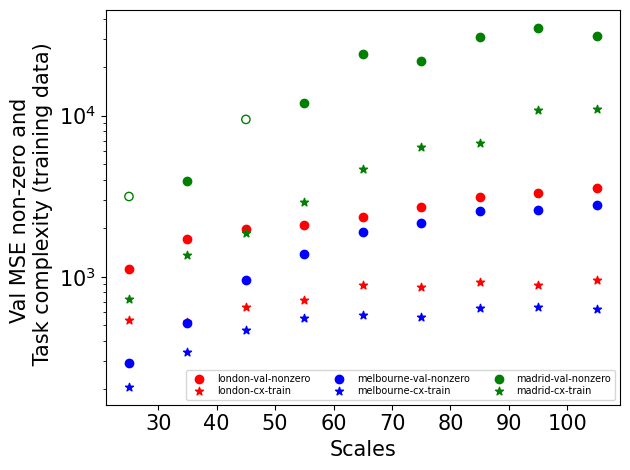

In [111]:
import pandas as pd

city_color = {"london" : "red", 
             "melbourne": "blue",
             "madrid": "green"}
df.head()

# scales
for city in config.city_list:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(scale, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(scale, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        df = pd.read_csv("PM_results_all_cities.csv")
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_only_back_margins_wide.csv")        


        for scale in config.scales[::-1]:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    range_ = [0]
                    
                    for i in range_:
                        if cityname in city_label_printed:
                            plt.scatter(scale, filtered_rows.iloc[i][CSR_type], marker='*',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(scale, filtered_rows.iloc[i][CSR_type], marker='*',color=city_color[cityname], label=cityname + "-cx-train", alpha=1)
                            city_label_printed.append(cityname)

plt.xlabel("Scales", fontsize=15)
plt.ylabel("Val MSE non-zero and \n Task complexity (training data)", fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=7, ncol=3, labelspacing=0.2)
plt.tight_layout()
plt.savefig("Scales_csr_val_combo.png")
plt.show()





In [108]:
df.head()

,cityname,i_o_length,prediction_horizon,grid_size,thresh,config_cx_sample_whole_data,CSR_MP_no_thresh_mean,CSR_MP_no_thresh_median,CSR_MP_count_y_exceeding_r_x,CSR_MP_sum_y_exceeding_r_x_max,...,CSR_NM_no_thresh_frac_sum,CSR_GB_no_thresh_mean,CSR_GB_no_thresh_median,CSR_GB_count_y_exceeding_r_x,CSR_GB_sum_y_exceeding_r_x_max,CSR_GB_sum_y_exceeding_r_x_mean,CSR_GB_sum_exp_y_exceeding_r_x_mean,CSR_GB_no_thresh_frac_mean_2,CSR_GB_no_thresh_frac_mean_2_exp,CSR_GB_no_thresh_frac_sum
0,madrid,4,1,25,100,3000,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,melbourne,4,1,25,100,3000,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,london,4,1,25,100,3000,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,madrid,4,1,35,100,3000,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,melbourne,4,1,35,100,3000,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df.head()

,cityname,i_o_length,prediction_horizon,grid_size,thresh,config_cx_sample_whole_data,CSR_MP_no_thresh_mean,CSR_MP_no_thresh_median,CSR_MP_count_y_exceeding_r_x,CSR_MP_sum_y_exceeding_r_x_max,...,CSR_NM_no_thresh_frac_sum,CSR_GB_no_thresh_mean,CSR_GB_no_thresh_median,CSR_GB_count_y_exceeding_r_x,CSR_GB_sum_y_exceeding_r_x_max,CSR_GB_sum_y_exceeding_r_x_mean,CSR_GB_sum_exp_y_exceeding_r_x_mean,CSR_GB_no_thresh_frac_mean_2,CSR_GB_no_thresh_frac_mean_2_exp,CSR_GB_no_thresh_frac_sum
0,madrid,1,4,25,100,3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,melbourne,1,4,25,100,3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,london,1,4,25,100,3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,madrid,1,4,35,100,3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,melbourne,1,4,35,100,3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


GIGO case:  melbourne-1-1-55-
GIGO case:  melbourne-2-1-55-
GIGO case:  madrid-1-1-55-
GIGO case:  madrid-7-1-55-
GIGO case:  madrid-8-1-55-


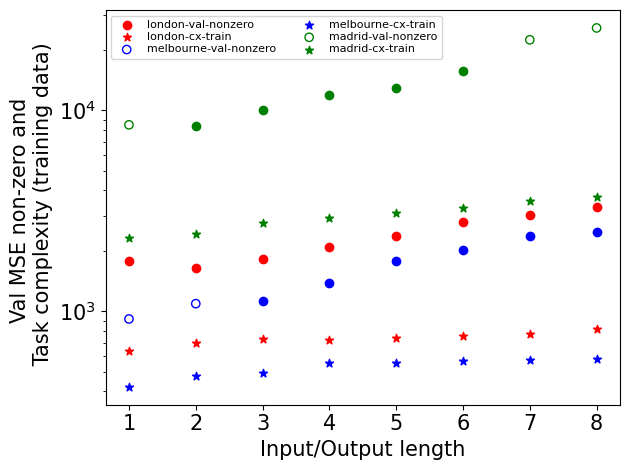

In [100]:
import pandas as pd

city_color = {"london" : "red", 
             "melbourne": "blue",
             "madrid": "green"}
df.head()

# scales
for city in config.city_list:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(i_o_length, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(i_o_length, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        df = pd.read_csv("PM_results_all_cities.csv")


        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths:
                for pred_horiz in config.pred_horiz_def:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    range_ = [0]
                    
                    for i in range_:
                        if cityname in city_label_printed:
                            plt.scatter(i_o_length, filtered_rows.iloc[i][CSR_type], marker='*',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(i_o_length, filtered_rows.iloc[i][CSR_type], marker='*',color=city_color[cityname], label=cityname + "-cx-train", alpha=1)
                            city_label_printed.append(cityname)

plt.xlabel("Input/Output length", fontsize=15)
plt.ylabel("Val MSE non-zero and \n Task complexity (training data)", fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left", fontsize=8, ncol=2, labelspacing=0.2)
plt.tight_layout()
plt.savefig("IO_horiz_csr_val_combo.png")
plt.show()

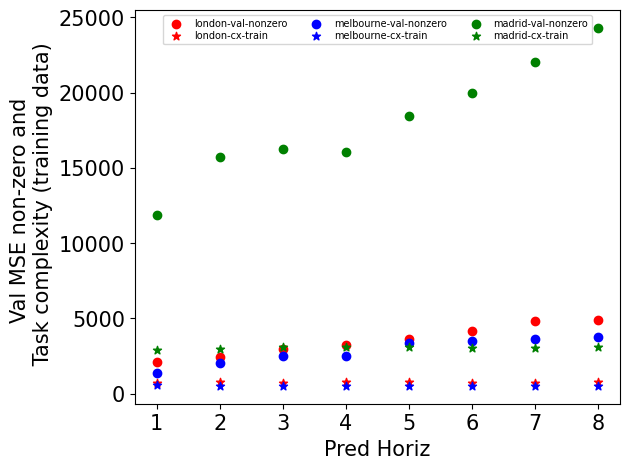

In [126]:
import pandas as pd

city_color = {"london" : "red", 
             "melbourne": "blue",
             "madrid": "green"}
df.head()

# scales
for city in config.city_list:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(pred_horiz, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(pred_horiz, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        df = pd.read_csv("PM_results_all_cities.csv")


        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    range_ = [0]
                    
                    for i in range_:
                        if cityname in city_label_printed:
                            plt.scatter(pred_horiz, filtered_rows.iloc[i][CSR_type], marker='*',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(pred_horiz, filtered_rows.iloc[i][CSR_type], marker='*',color=city_color[cityname], label=cityname + "-cx-train", alpha=1)
                            city_label_printed.append(cityname)

plt.xlabel("Pred Horiz", fontsize=15)
plt.ylabel("Val MSE non-zero and \n Task complexity (training data)", fontsize=15)
# plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper center", fontsize=7, ncol=3, labelspacing=0.2)
plt.tight_layout()
plt.savefig("Pred_horiz_csr_val_combo.png")
plt.show()